In [1]:
setwd(here::here())

In [2]:
library("metacell")
library("Matrix")
library("ggplot2")
library("ggrepel")
library("tgstat")
library("zoo")
library("qvalue")
library("devtools")
library("data.table")
library("tidyverse")
library("tglkmeans")
library('RColorBrewer')


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: usethis

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.2      v dplyr   1.0.10
v tidyr   1.2.0      v stringr 1.4.0 
v readr   2.1.0      v forcats 1.0.0 
v purrr   0.3.4      

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x tidyr::expand()    masks Matrix::expand()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x tidyr::pack()      masks Matrix::pack()
x purrr::transpose() masks data.table::transpose()
x tidyr::unpack()    masks Matrix::unpack()



In [3]:
source("scripts/manifold_2d_proj_hr.R")
scdb_init("scrna_db/", force_reinit=T)

fig_dir <- "figs/"
if(!dir.exists(fig_dir)) dir.create(fig_dir)
scfigs_init(fig_dir)

mat_exe <- scdb_mat("exe")
mc_exe <- scdb_mc("exe")
gset_exe = scdb_gset("exe")
mc2d_exe <- scdb_mc2d(id = "exe_umap")
md_exe <- mat_exe@cell_metadata[names(mc_exe@mc),]

mat_emb <- scdb_mat("emb")
mc_emb <- scdb_mc("emb")
gset_emb = scdb_gset("emb")
mc2d_emb <- scdb_mc2d(id = "emb_umap")
md_emb <- mat_emb@cell_metadata[names(mc_emb@mc),]

mat_embexe <- scdb_mat("embexe")
mc_embexe <- scdb_mc("embexe_recolored")
mc2d_embexe <- scdb_mc2d(id = "embexe_recolored_umap")
md_embexe <- mat_embexe@cell_metadata[names(mc_embexe@mc),]

initializing scdb to scrna_db/



In [4]:
scdb_init("scrna_db_mm10_star/", force_reinit=T)

mat_all = scdb_mat('embexe_bmp4_og2_stelzer_star')
mc_all <- scdb_mc("embexe_bmp4_og2_star")
md_all <- mat_all@cell_metadata[colnames(mat_all@mat),]

cmp_annot = readRDS('data/cmp_annot_embexe_bmp4.RData')
cmp_time = read.table("data/embexe_bmp4/time_match/time_match_summary.txt", header = T)
wt_age = read.table('data/embexe.transcriptional_rank_developmental_time_with_age_group.tsv',sep = '\t',h = T)
mc_wt <- scdb_mc("mm_embexe")
cmp_time = cmp_time  %>% left_join( wt_age %>% select(transcriptional_rank,developmental_time,age_group,morphological_stage) %>% rename(best_rank_query = transcriptional_rank))

# included_colors = mc_embexe@color_key$color[c(1:38,43:50)]
included_colors = mc_embexe@color_key$color

initializing scdb to scrna_db_mm10_star/

Joining, by = "best_rank_query"


In [5]:
germline_ko_embryos = c("x4e26_Embryo_ExE_Bmp4_KO","x4e37_Embryo_ExE_Bmp4_KO",'x6e9_Embryo_ExE_Bmp4_KO',
                          "x4e34_Embryo_ExE_Bmp4_KO","x4e35_Embryo_ExE_Bmp4_KO")

germline_control_embryos = c('x4e19_Embryo_ExE_Bmp4_KO','x4e22_Embryo_ExE_Bmp4_KO',
                    'x4e31_Embryo_ExE_Bmp4_KO','x6e3_Embryo_ExE_Bmp4_KO',
                    'x6e2_Embryo_ExE_Bmp4_KO','x6e1_Embryo_ExE_Bmp4_KO',
                    'x6e6_Embryo_ExE_Bmp4_KO','x6e4_Embryo_ExE_Bmp4_KO')

In [6]:
col_to_ct =  mc_embexe@color_key$group
names(col_to_ct) = mc_embexe@color_key$color
ct_to_col = mc_embexe@color_key$color
names(ct_to_col) = mc_embexe@color_key$group

shades_rdbu <- rev(colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100))
shades_blues <- colorRampPalette(RColorBrewer::brewer.pal(9,"Blues"))(100)
shades_reds <- colorRampPalette(RColorBrewer::brewer.pal(9,"Reds"))(100)
shades_yellows <- colorRampPalette(RColorBrewer::brewer.pal(9,"YlOrBr"))(100)
shades_greys <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greys"))(100)
shades_greens <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greens"))(100)
shades_purples <- colorRampPalette(RColorBrewer::brewer.pal(9,"BuPu"))(100)

In [7]:
exe_project_cells = rownames(md_embexe)[(md_embexe[,"Experiment"] != "Wildtype project") & (md_embexe$embryo %in% wt_age$embryo)]

emb_age_df = unique(md_embexe[exe_project_cells,c("embryo","transcriptional_rank","developmental_time")])
emb_age_df = emb_age_df[order(emb_age_df$transcriptional_rank),]

sc_time_annot = data.frame("cell" = exe_project_cells, "embryo" = md_embexe[exe_project_cells,"embryo"])
sc_time_annot = left_join(sc_time_annot,emb_age_df,by = "embryo")
f = !is.na(sc_time_annot$developmental_time)
sc_time = sc_time_annot$developmental_time[f]
names(sc_time) = sc_time_annot$cell[f]

mc_time = tapply(sc_time,mc_embexe@mc[names(sc_time)],mean)

In [8]:
plot_size <- function(w,h){
    options(repr.plot.width=w, repr.plot.height=h)
}

## FIG 4 a

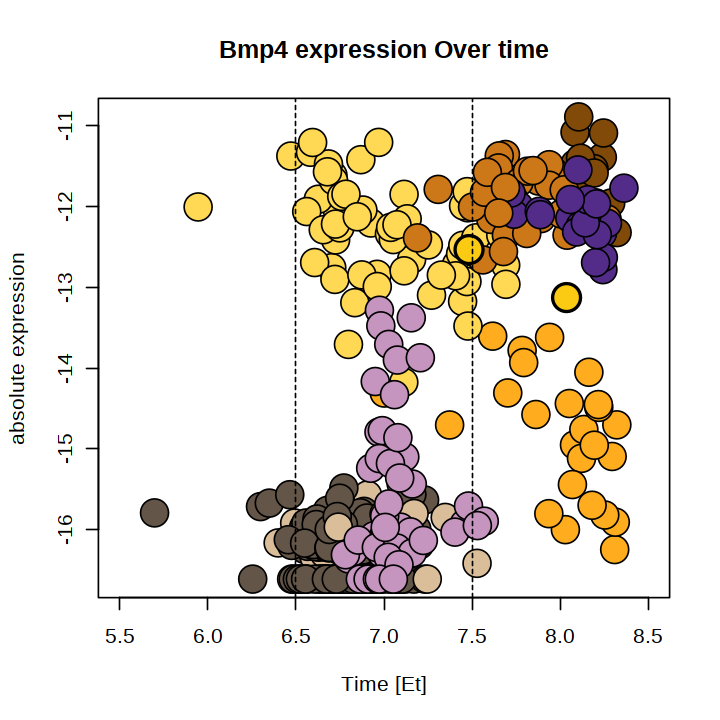

In [9]:
cts_to_plot <- c("Chorion progenitors","Epiblast","PGC","Primitive streak","Chorion",
                 "Early nascent mesoderm","Allantois","Amnion/Chorion progenitor","Amnion/Chorion")
cols_to_plot <- array(ct_to_col[cts_to_plot])
mcs_to_plot <- which(mc_embexe@colors %in% cols_to_plot)
pgc_mcs <- which(mc_embexe@colors %in% "#FACB12")

plot_size(6,6)

plot(x = mc_time[mcs_to_plot], 
     y = log2(mc_embexe@e_gc["Bmp4",mcs_to_plot] + 1e-5),
     pch=21,cex=3,
     main = "Bmp4 expression Over time",
     ylab = "absolute expression",
     xlab = "Time [Et]",
     xlim = c(5.5,8.5),
     bg=mc_embexe@colors[mcs_to_plot])

points(x = mc_time[pgc_mcs], 
     y = log2(mc_embexe@e_gc["Bmp4",pgc_mcs] + 1e-5),
     pch=21,cex=3,lwd=2)

abline(v = 6.5, lty = "dashed")
abline(v = 7.5, lty = "dashed")

## FIG 4d

In [10]:
all_included_cells = names(mc_all@mc)[mc_all@colors[mc_all@mc] %in% included_colors]

wt_cells = names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] %in% included_colors]
wt_cells = wt_cells[ !is.na(mat_all@cell_metadata[wt_cells,"developmental_time"])]
wt_cells = wt_cells[mat_all@cell_metadata[wt_cells,"Experiment"] != "Wildtype project"]
wt_cells = wt_cells[mat_all@cell_metadata[wt_cells,"developmental_time"] > cmp_time[ cmp_time$embryo %in% "x6e9_Embryo_ExE_Bmp4_KO","developmental_time"]]
# wt_cells = wt_cells[mat_all@cell_metadata[wt_cells,"developmental_time"] > 7.9]
wt_cells = intersect(wt_cells, names(mc_all@mc))

wt_exe_vs_ct = table(mat_all@cell_metadata[wt_cells,"transcriptional_rank"],
                     factor(x = mc_all@colors[mc_all@mc[wt_cells]],levels = mc_embexe@color_key$color[43:50]))


In [11]:
germline_time <- array(data = cmp_time[ cmp_time$embryo %in% germline_ko_embryos,"developmental_time"], 
                       dimnames = list(cmp_time[ cmp_time$embryo %in% germline_ko_embryos,"embryo"]))
germline_time <- germline_time[order(as.numeric(germline_time))]

all_included_cells = names(mc_all@mc)[mc_all@colors[mc_all@mc] %in% mc_embexe@color_key$color[c(1:41,43:50)]]
germline_ko_cells <- rownames(mat_all@cell_metadata[names(mc_all@mc),])[mat_all@cell_metadata[names(mc_all@mc),"embryo"] %in% germline_ko_embryos]
germline_ko_cells_old <- intersect(germline_ko_cells, all_included_cells)

# germline_ko_cells_old <- rownames(md_all)[md_all$embryo %in% names(germline_time)[germline_time > cmp_time[ cmp_time$embryo %in% "x6e9_Embryo_ExE_Bmp4_KO","developmental_time"]]]
# germline_ko_cells_old <- rownames(md_all)[md_all$embryo %in% names(germline_time)[germline_time > 7.9]]

germline_exe_ko_ct = table( md_all[germline_ko_cells_old,"embryo"],
                     factor(x = cmp_annot$query_cls_col[germline_ko_cells_old],levels = mc_embexe@color_key$color[43:50]))

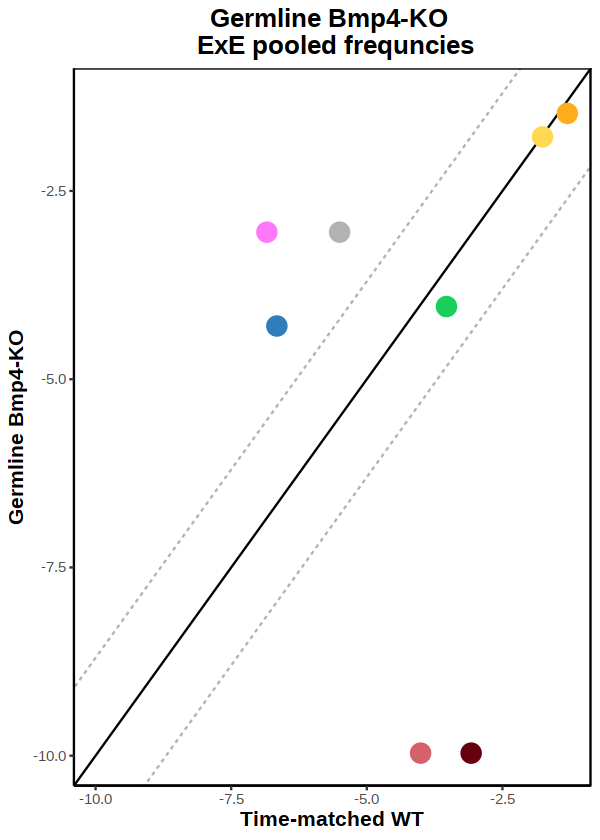

In [12]:
WT_pooled_EXE_ct_comp <- colSums(wt_exe_vs_ct)/sum(colSums(wt_exe_vs_ct))
GERMLINE_pooled_EXE_ct_comp <- colSums(germline_exe_ko_ct)/sum(colSums(germline_exe_ko_ct))

EXE_Ct_comp_df <- data.frame(wt = log2(WT_pooled_EXE_ct_comp + 1e-3), 
                             germline = log2(GERMLINE_pooled_EXE_ct_comp + 1e-3), 
                             col = names(WT_pooled_EXE_ct_comp))

plot_size(5,7)

min_val <- min(EXE_Ct_comp_df$wt,EXE_Ct_comp_df$tetraploid,EXE_Ct_comp_df$germline)
max_val <- max(EXE_Ct_comp_df$wt,EXE_Ct_comp_df$tetraploid,EXE_Ct_comp_df$germline)

ggplot(data = EXE_Ct_comp_df,aes(wt, germline, col=col)) +
    geom_abline(slope = 1,intercept = 0) +
  geom_abline(slope = 1,intercept = 1.3, col = "gray70",linetype = 'dashed') +
  geom_abline(slope = 1,intercept = -1.3, col = "gray70",linetype = 'dashed') +
  geom_point(size = 5) +
  ggtitle(label = "Germline Bmp4-KO \n ExE pooled frequncies") +
  scale_color_identity() +
  ylim(min_val,max_val) + 
  xlim(min_val,max_val) +
  ylab("Germline Bmp4-KO") +
  xlab("Time-matched WT") +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.title = element_text(face = "bold",size = 12),
        panel.grid = element_blank(),panel.border = element_rect(fill=NA),legend.position="None")

## Extended Data Fig 8c

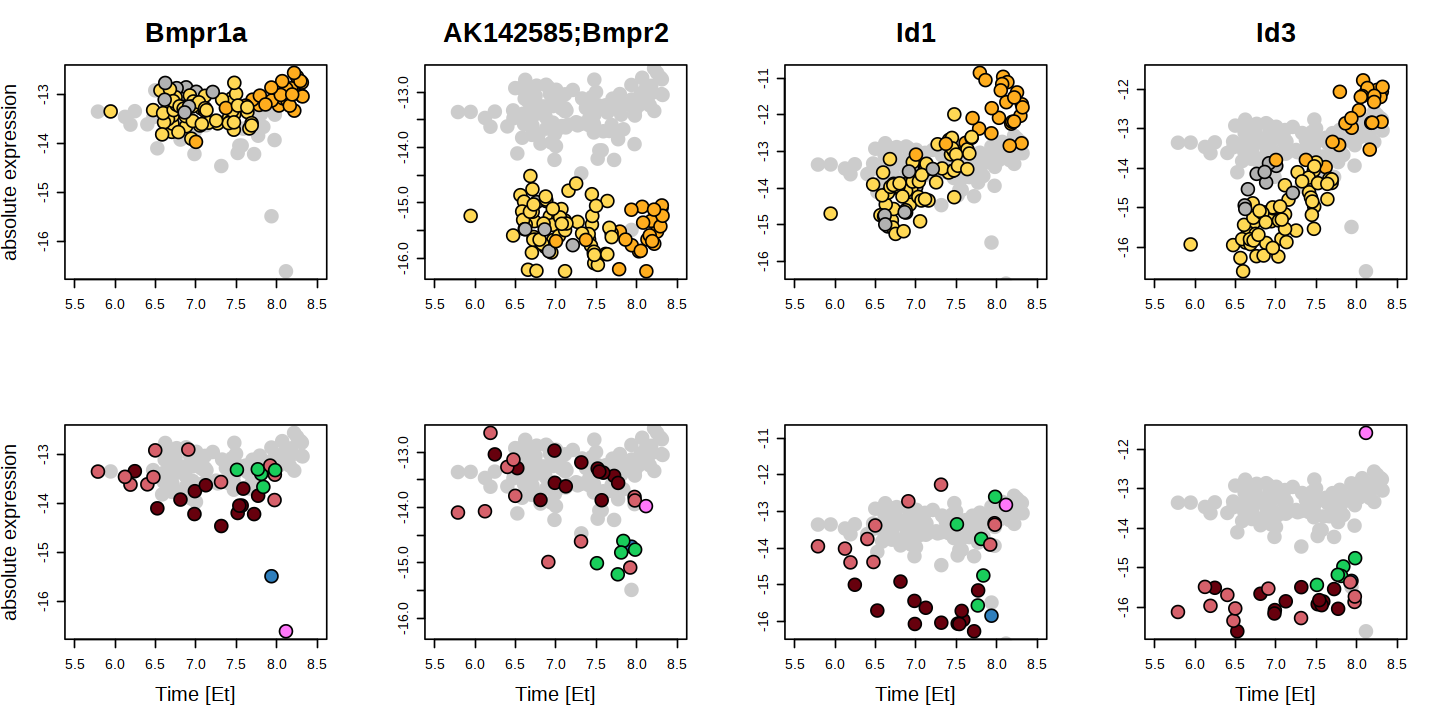

In [13]:
genes_to_plot <- c("Bmpr1a",'AK142585;Bmpr2',"Id1","Id3")
plot_size(12,6)
par(mfrow = c(2,4))

mcs_Chorion <- which(mc_embexe@colors %in% c("#ffad1e","#ffd854","#b2b2b2"))
mcs_EPC <-  which(mc_embexe@colors %in% c("#19ce5b","#d6616b","#67000d","#2e7ebc","#ff78fa"))
mcs_both <- c(mcs_Chorion,mcs_EPC)

plot(mc_time[mcs_both],
    log2(mc_embexe@e_gc[genes_to_plot[1],mcs_both] + 1e-5), 
    pch = 19, cex = 2, cex.main = 2,cex.lab = 1.5,
     col = "#CCCCCC", 
     main = genes_to_plot[1],
     ylab = "absolute expression",
     xlab = NA,
     ylim = c(min(log2(mc_embexe@e_gc[genes_to_plot[1],mcs_both] + 1e-5)),
              max(log2(mc_embexe@e_gc[genes_to_plot[1],mcs_both] + 1e-5))),
     xlim = c(5.5,8.5))

points(mc_time[mcs_Chorion],
    log2(mc_embexe@e_gc[genes_to_plot[1],mcs_Chorion] + 1e-5),
    pch = 21, cex = 2, bg = mc_embexe@colors[mcs_Chorion])

###################################################################

plot(mc_time[mcs_both],
    log2(mc_embexe@e_gc[genes_to_plot[1],mcs_both] + 1e-5), 
    pch = 19, cex = 2, cex.main = 2,cex.lab = 1.5,
     col = "#CCCCCC", 
     main = genes_to_plot[2],
          ylim = c(min(log2(mc_embexe@e_gc[genes_to_plot[2],mcs_both] + 1e-5)),
              max(log2(mc_embexe@e_gc[genes_to_plot[2],mcs_both] + 1e-5))),
     ylab = NA,
     xlab = NA,
     xlim = c(5.5,8.5))

points(mc_time[mcs_Chorion],
    log2(mc_embexe@e_gc[genes_to_plot[2],mcs_Chorion] + 1e-5),
    pch = 21, cex = 2, bg = mc_embexe@colors[mcs_Chorion])

###################################################################

plot(mc_time[mcs_both],
    log2(mc_embexe@e_gc[genes_to_plot[1],mcs_both] + 1e-5), 
    pch = 19, cex = 2, cex.main = 2,cex.lab = 1.5,
     col = "#CCCCCC", 
     main = genes_to_plot[3],
          ylim = c(min(log2(mc_embexe@e_gc[genes_to_plot[3],mcs_both] + 1e-5)),
              max(log2(mc_embexe@e_gc[genes_to_plot[3],mcs_both] + 1e-5))),
     ylab = NA,
     xlab = NA,
     xlim = c(5.5,8.5))

points(mc_time[mcs_Chorion],
    log2(mc_embexe@e_gc[genes_to_plot[3],mcs_Chorion] + 1e-5),
    pch = 21, cex = 2, bg = mc_embexe@colors[mcs_Chorion])

###################################################################

plot(mc_time[mcs_both],
    log2(mc_embexe@e_gc[genes_to_plot[1],mcs_both] + 1e-5), 
    pch = 19, cex = 2, cex.main = 2,cex.lab = 1.5,
     col = "#CCCCCC", 
          ylim = c(min(log2(mc_embexe@e_gc[genes_to_plot[4],mcs_both] + 1e-5)),
              max(log2(mc_embexe@e_gc[genes_to_plot[4],mcs_both] + 1e-5))),
     main = genes_to_plot[4],
     ylab = NA,
     xlab = NA,
     xlim = c(5.5,8.5))

points(mc_time[mcs_Chorion],
    log2(mc_embexe@e_gc[genes_to_plot[4],mcs_Chorion] + 1e-5),
    pch = 21, cex = 2, bg = mc_embexe@colors[mcs_Chorion])

###################################################################

plot(mc_time[mcs_both],
    log2(mc_embexe@e_gc[genes_to_plot[1],mcs_both] + 1e-5), 
    pch = 19, cex = 2, cex.main = 2,cex.lab = 1.5,
     col = "#CCCCCC", 
          ylim = c(min(log2(mc_embexe@e_gc[genes_to_plot[1],mcs_both] + 1e-5)),
              max(log2(mc_embexe@e_gc[genes_to_plot[1],mcs_both] + 1e-5))),
     ylab = "absolute expression",
     xlab = "Time [Et]",
     xlim = c(5.5,8.5))

points(mc_time[mcs_EPC],
    log2(mc_embexe@e_gc[genes_to_plot[1],mcs_EPC] + 1e-5),
    pch = 21, cex = 2, bg = mc_embexe@colors[mcs_EPC])

###################################################################

plot(mc_time[mcs_both],
    log2(mc_embexe@e_gc[genes_to_plot[1],mcs_both] + 1e-5), 
    pch = 19, cex = 2, cex.main = 2,cex.lab = 1.5,
     col = "#CCCCCC", 
          ylim = c(min(log2(mc_embexe@e_gc[genes_to_plot[2],mcs_both] + 1e-5)),
              max(log2(mc_embexe@e_gc[genes_to_plot[2],mcs_both] + 1e-5))),
     ylab = NA,
     xlab = "Time [Et]",
     xlim = c(5.5,8.5))

points(mc_time[mcs_EPC],
    log2(mc_embexe@e_gc[genes_to_plot[2],mcs_EPC] + 1e-5),
    pch = 21, cex = 2, bg = mc_embexe@colors[mcs_EPC])

###################################################################

plot(mc_time[mcs_both],
    log2(mc_embexe@e_gc[genes_to_plot[1],mcs_both] + 1e-5), 
    pch = 19, cex = 2, cex.main = 2,cex.lab = 1.5,
          ylim = c(min(log2(mc_embexe@e_gc[genes_to_plot[3],mcs_both] + 1e-5)),
              max(log2(mc_embexe@e_gc[genes_to_plot[3],mcs_both] + 1e-5))),
     col = "#CCCCCC", 
     ylab = NA,
     xlab = "Time [Et]",
     xlim = c(5.5,8.5))

points(mc_time[mcs_EPC],
    log2(mc_embexe@e_gc[genes_to_plot[3],mcs_EPC] + 1e-5),
    pch = 21, cex = 2, bg = mc_embexe@colors[mcs_EPC])

###################################################################

plot(mc_time[mcs_both],
    log2(mc_embexe@e_gc[genes_to_plot[1],mcs_both] + 1e-5), 
    pch = 19, cex = 2, cex.main = 2,cex.lab = 1.5,
     col = "#CCCCCC", 
     ylab = NA,
          ylim = c(min(log2(mc_embexe@e_gc[genes_to_plot[4],mcs_both] + 1e-5)),
              max(log2(mc_embexe@e_gc[genes_to_plot[4],mcs_both] + 1e-5))),
     xlab = "Time [Et]",
     xlim = c(5.5,8.5))

points(mc_time[mcs_EPC],
    log2(mc_embexe@e_gc[genes_to_plot[4],mcs_EPC] + 1e-5),
    pch = 21, cex = 2, bg = mc_embexe@colors[mcs_EPC])

## Extended Data Figure 8e

In [14]:
bad_genes <- read.table('data/embexe.bad_genes.txt')[,1]
batch_genes <- read.table('data/bmp4_ko_expression_analysis_bad_genes.tsv')[,1]
batch_genes <- setdiff(batch_genes, grep("Ifitm", batch_genes, v = T))

bad_gns <- unique(c(grep("Hsp", rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("BEX", rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("MT", rownames(mat_all@mat),v=T, ignore.case = T),
                             grep("CDK",rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("RN[0-9]", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("Nduf", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("Mrp", rownames(mat_all@mat),v=T, ignore.case = T),
                    grep("\\bcox", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("\\bRp[l|s]", rownames(mat_all@mat),v=T, ignore.case = T),
                    "Top2a", "Ube2c", "Pcna", "Mki67", "Cenpf","Hist1h1a", "Hist1h1b"))

bad_genes <- union(bad_genes, bad_gns)
bad_genes <- union(bad_genes, batch_genes)

genes_f <- rownames(mat_all@mat)[! rownames(mat_all@mat) %in% bad_genes]
genes_f <- unique(c(genes_f,"Id3","Id1"))

gexp_per_col_WT <- t(tgs_matrix_tapply(x = mat_all@mat[genes_f,wt_cells],
                         index = mc_all@colors[mc_all@mc[wt_cells]],
                         fun = sum))

gexp_per_col_WT <- t(t(gexp_per_col_WT)/colSums(gexp_per_col_WT))
l_gexp_per_col_WT <- log2(gexp_per_col_WT + 1e-5)

################################################################################################################################
germline_ko_cells_old <- intersect(germline_ko_cells_old, names(mc_all@mc))

gexp_per_col_germline_KO = t(tgs_matrix_tapply(x = mat_all@mat[genes_f,germline_ko_cells_old],
                         index = mc_all@colors[mc_all@mc[germline_ko_cells_old]],
                         fun = sum))

gexp_per_col_germline_KO = t(t(gexp_per_col_germline_KO)/colSums(gexp_per_col_germline_KO))
l_gexp_per_col_germline_KO = log2(gexp_per_col_germline_KO + 1e-5)

In [15]:
ct_to_col

Forebrain/Midbrain/Hindbrain            Rostral neural plate 
                      "#647A4F"                       "#649146" 
               Surface ectoderm                    Neural crest 
                      "#f7f79e"                       "#C3C388" 
            Caudal neural plate         Neural tube/Floor plate 
                      "#354E23"                       "#CDE088" 
            Definitive ectoderm               Tail bud - neural 
                      "#90BF75"                       "#8e7e59" 
                       Epiblast                             PGC 
                      "#635547"                       "#FACB12" 
                Caudal epiblast                Primitive streak 
                      "#9e6762"                       "#DABE99" 
            Tail bud - mesoderm           Late nascent mesoderm 
                      "#703C37"                       "#DFCDE4" 
         Early nascent mesoderm                 Caudal mesoderm 
                      "#C594BF"                       "#1a3f52" 
            Presomitic mesoderm                Somitic mesoderm 
                      "#A8DBF7"                       "#1AA2EB" 
              Paraxial mesoderm                Rostral mesoderm 
                      "#408DA1"                       "#8DB5CE" 
      Cardiopharyngeal mesoderm                  Cardiomyocytes 
                      "#53f1fc"                       "#B51D8D" 
      Amnion/Chorion progenitor                  Amnion/Chorion 
                      "#cc7818"                       "#824A09" 
Lateral & intermediate mesoderm                    ExE mesoderm 
                      "#45d1c5"                       "#8870ad" 
                      Allantois  Haematoendothelial progenitors 
                      "#532C8A"                       "#FBBE92" 
              Endothelial cells               Blood progenitors 
                      "#ff891c"                       "#c9a997" 
                    Erythroid 1                     Erythroid 2 
                      "#C72228"                       "#D96B2B" 
                    Erythroid 3       Anterior Primitive Streak 
                      "#FF5608"                       "#c19f70" 
                 Node/Notochord             Definitive endoderm 
                      "#0F4A9C"                       "#F397C0" 
                            Gut                         Hindgut 
                      "#EF5A9D"                       "#F25CD4" 
              Visceral endoderm    Visceral endoderm - anterior 
                      "#F6BFCB"                       "#BA9BA1" 
          ExE visceral endoderm               Parietal endoderm 
                      "#7F6874"                       "#1A1A1A" 
                        Chorion             Chorion progenitors 
                      "#ffad1e"                       "#ffd854" 
           Intermediate Chorion                         SpT-Gly 
                      "#b2b2b2"                       "#19ce5b" 
                EPC progenitors                 TGC progenitors 
                      "#d6616b"                       "#67000d" 
                          p-TGC                         SpA-TGC 
                      "#2e7ebc"                       "#ff78fa" 
                 Maternal cells 
                       "gray40"

In [16]:
head(l_gexp_per_col_WT["Bmp2","#F6BFCB"])
head(l_gexp_per_col_germline_KO["Bmp2","#F6BFCB"])

head(l_gexp_per_col_WT["Bmp2","#BA9BA1"])
head(l_gexp_per_col_germline_KO["Bmp2","#BA9BA1"])

head(l_gexp_per_col_WT["Bmp2","#7F6874"])
head(l_gexp_per_col_germline_KO["Bmp2","#7F6874"])

mean(l_gexp_per_col_WT["Bmp2",c("#F6BFCB","#BA9BA1")])
mean(l_gexp_per_col_germline_KO["Bmp2",c("#F6BFCB","#BA9BA1")])

[1] -12.4482

[1] -11.50004

[1] -11.31937

[1] -10.80202

[1] -13.6998

[1] -12.83107

[1] -11.88378

[1] -11.15103

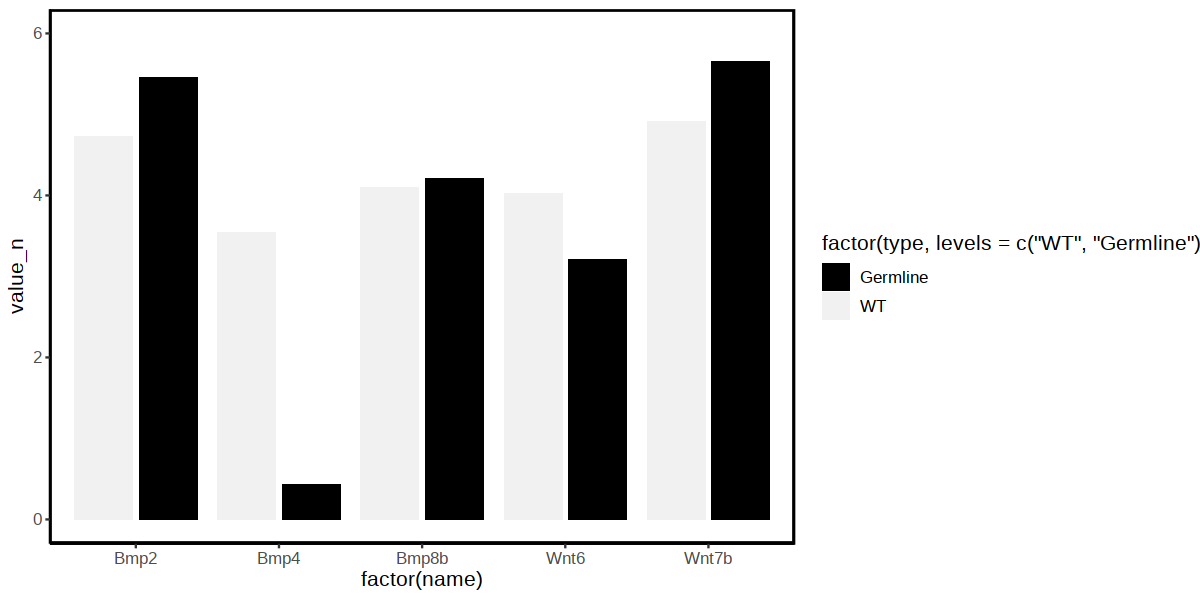

In [27]:
barplot_df <- data.frame("type" = c("WT","Germline"),
                        "Bmp4" = c(mean(l_gexp_per_col_WT["Bmp4",c("#ffad1e","#ffd854")]),
                                   mean(l_gexp_per_col_germline_KO["Bmp4",c("#ffad1e","#ffd854")])),
                        "Bmp8b" = c(mean(l_gexp_per_col_WT["Bmp8b",c("#ffad1e","#ffd854")]),
                                    mean(l_gexp_per_col_germline_KO["Bmp8b",c("#ffad1e","#ffd854")])),
                        "Bmp2" = c(mean(l_gexp_per_col_WT["Bmp2",c("#F6BFCB","#BA9BA1")]),
                                    mean(l_gexp_per_col_germline_KO["Bmp2",c("#F6BFCB","#BA9BA1")])),
                        "Wnt6" = c(mean(l_gexp_per_col_WT["Wnt6",c("#ffad1e","#ffd854")]),
                                    mean(l_gexp_per_col_germline_KO["Wnt6",c("#ffad1e","#ffd854")])),
                        "Wnt7b" = c(mean(l_gexp_per_col_WT["Wnt7b",c("#ffad1e","#ffd854")]),
                                    mean(l_gexp_per_col_germline_KO["Wnt7b",c("#ffad1e","#ffd854")])))

barplot_df <- barplot_df %>% pivot_longer(cols = 2:ncol(barplot_df))
barplot_df <- as.data.frame(barplot_df)
rownames(barplot_df) <- 1:nrow(barplot_df)
barplot_df$value_n <- barplot_df$value - log2(1e-5)

plot_size(10,5)
ggplot(data = barplot_df, aes(x = factor(name), y = value_n, fill = factor(type, levels = c("WT","Germline")))) +
geom_col(position = "dodge2") +
ylim(0,6)+
scale_fill_manual(values = c("Germline" = "black","WT" = "#F1F1F1")) +
theme(text = element_text(size = 12),
                panel.border = element_rect(fill=NA, size = 1))

In [ ]:
col_to_ct =  mc_all@color_key$group
names(col_to_ct) = mc_all@color_key$color
ct_to_col = mc_all@color_key$color
names(ct_to_col) = mc_all@color_key$group

cts_germline = as.data.frame(enframe(colnames(l_gexp_per_col_germline_KO))) %>% mutate("type" = col_to_ct[value])
cts_wt = as.data.frame(enframe(colnames(l_gexp_per_col_WT))) %>% mutate("type" = col_to_ct[value])

In [ ]:
barplot_df <- data.frame("type" = c("WT","Germline"),
                         "Wnt3_APS" = c(l_gexp_per_col_WT["Wnt3",c("#c19f70")],
                                        l_gexp_per_col_germline_KO["Wnt3",c("#c19f70")]),

                        "Wnt3_DE" = c(l_gexp_per_col_WT["Wnt3",c("#F397C0")],
                                           l_gexp_per_col_germline_KO["Wnt3",c("#F397C0")]))

barplot_df <- barplot_df %>% pivot_longer(cols = 2:3)
barplot_df <- as.data.frame(barplot_df)
rownames(barplot_df) <- 1:nrow(barplot_df)
barplot_df$value_n <- barplot_df$value - log2(3e-5)

plot_size(10,5)
ggplot(data = barplot_df, aes(x = factor(name), y = value_n, fill = factor(type, levels = c("WT","Germline")))) +
geom_col(position = "dodge2") +
ylab("absolute expression (Log trans)") +
xlab("")+
scale_fill_manual(values = c("Germline" = "black","WT" = "grey80")) +
theme(text = element_text(size = 15),
                panel.border = element_rect(fill=NA, size = 1))

## FIG 4g - Placental weights and JZ area

In [ ]:
placenta_df <- read.csv("data/PLACENTAS_AREAS.csv", header = T, row.names = "X")
placenta_df$genotype <- ifelse(rownames(placenta_df) %in% grep("KO",placenta_df$GENO),"ExE Bmp4-KO","Control")

t.test(placenta_df[placenta_df$genotype == "ExE Bmp4-KO","Area"],placenta_df[placenta_df$genotype == "Control","Area"])

plot_size(5,5)
ggplot(placenta_df, aes(factor(genotype), Area, fill = factor(genotype))) +
geom_boxplot() +
scale_fill_manual(values = c("ExE Bmp4-KO" = "#7A7A7A","Control" = "#F1F1F1")) +
geom_jitter(width = .1) +
theme(text = element_text(size = 12),
                panel.border = element_rect(fill=NA, size = 1))

In [ ]:
placenta_w_df <- read.csv("data/PLACENTAS_WEIGHT.csv", header = T, row.names = "X")
placenta_w_df$genotype <- ifelse(rownames(placenta_w_df) %in% grep("KO",placenta_w_df$GENO),"ExE Bmp4-KO","Control")

t.test(placenta_w_df[placenta_w_df$genotype == "ExE Bmp4-KO","Weight"],placenta_w_df[placenta_w_df$genotype == "Control","Weight"])

plot_size(5,5)
ggplot(placenta_w_df, aes(factor(genotype), Weight, fill = factor(genotype))) +
geom_boxplot() +
scale_fill_manual(values = c("ExE Bmp4-KO" = "#7A7A7A","Control" = "#F1F1F1")) +
geom_jitter(width = .1) +
theme(text = element_text(size = 12),
                panel.border = element_rect(fill=NA, size = 1))